# Drug Review Sentiment Analysis

In [5]:
import boto3

bucket_name = 'drug-review-sentiment-analysis'

s3 = boto3.resource('s3')

try:
    s3.create_bucket(Bucket=bucket_name)
    print("S3 Bucket has been created successfully")
except Exception as e:
    print('S3 error: ', e)

S3 Bucket has been created successfully


## 1. Data Preparation
> - Clean
> - Pre-processing
> - Transform

#### 1.1 Data Collection

In [2]:
import pandas as pd

df_data = pd.read_csv('data.tsv', sep='\t', index_col=0)
df_data.reset_index(inplace=True)
df_data.rename(columns={'index': 'UniqueId'}, inplace=True)

print("Shape of dataset:", df_data.shape)

Shape of dataset: (166, 7)


In [3]:
print(df_data.head())

   UniqueId                  drugName                     condition  \
0    206461                 Valsartan  Left Ventricular Dysfunction   
1     95260                Guanfacine                          ADHD   
2     92703                    Lybrel                 Birth Control   
3    138000                Ortho Evra                 Birth Control   
4     35696  Buprenorphine / naloxone             Opiate Dependence   

                                              review  rating  \
0  "It has no side effect, I take it in combinati...     9.0   
1  "My son is halfway through his fourth week of ...     8.0   
2  "I used to take another oral contraceptive, wh...     5.0   
3  "This is my first time using any form of birth...     8.0   
4  "Suboxone has completely turned my life around...     9.0   

                date  usefulCount  
0       May 20, 2012           27  
1     April 27, 2010          192  
2  December 14, 2009           17  
3   November 3, 2015           10  
4  Novem

#### 1.1. Check for duplicate UniqueIds

In [4]:
duplicate_count = df_data['UniqueId'].duplicated().sum()

if duplicate_count > 0:
    print(f"Warning: {duplicate_count} duplicate UniqueId(s) found!")
else:
    print("No duplicates found in the UniqueId column")

No duplicates found in the UniqueId column


#### 1.1. Identify Target and Features


#### 1.2. Remove Unnecessary Columns

#### 1.4. Handle Missing Values

#### 1.5. Add a new column `sentiment`

In [5]:
def map_sentiment(rating):
    return '1' if rating >= 7 else '0'

df_data['label'] = df_data['rating'].apply(map_sentiment)

# Rename columns for Hugging Face format
data_final = df_data.rename(columns={'review': 'text'})[['text', 'label']]

print(data_final.head())

                                                text label
0  "It has no side effect, I take it in combinati...     1
1  "My son is halfway through his fourth week of ...     1
2  "I used to take another oral contraceptive, wh...     0
3  "This is my first time using any form of birth...     1
4  "Suboxone has completely turned my life around...     1


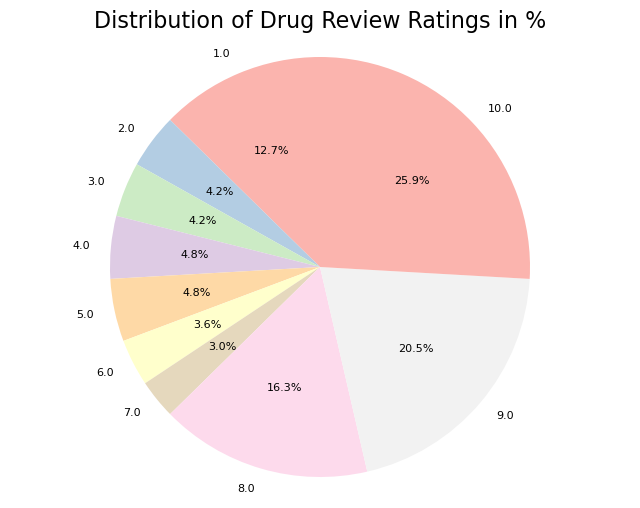

In [6]:
import matplotlib.pyplot as plt

# Group the data by the 'rating' column and calculate the counts
rating_counts = df_data['rating'].value_counts().sort_index()

# Extract labels (rating levels) and corresponding percentages
labels = rating_counts.index
sizes = (rating_counts / rating_counts.sum()) * 100  # Convert counts to percentages

# Plot the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 8}, colors=plt.cm.Pastel1.colors)
plt.title('Distribution of Drug Review Ratings in %', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular
plt.show()

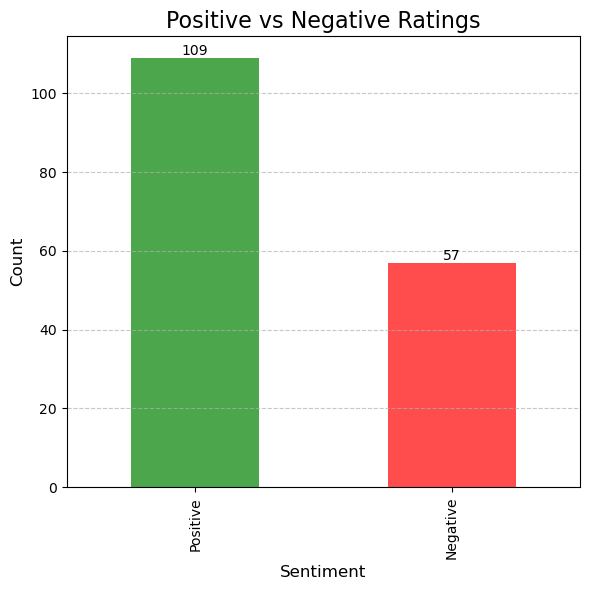

In [7]:
# Count the positive and negative ratings
sentiment_counts = df_data['label'].value_counts()

# Define the figure and grid
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the grid chart as a bar plot
sentiment_counts.plot(kind='bar', ax=ax, color=['green', 'red'], alpha=0.7)

# Add titles and labels
ax.set_title('Positive vs Negative Ratings', fontsize=16)
ax.set_xlabel('Sentiment', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_xticks([0, 1])
ax.set_xticklabels(['Positive', 'Negative'], fontsize=10)
ax.bar_label(ax.containers[0])  # Add count labels on bars

# Show the plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### 1.6. Text Processing

In [8]:
import re
from html import unescape

def preprocess_review(text):
    # Unescape HTML entities
    text = unescape(text)

    # Remove unwanted characters (e.g., double quotes, commas, hyphens)
    text = re.sub(r'[\"\'\,\-]', '', text)

    # Normalize whitespace (remove extra spaces)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

data_final.loc['text'] = data_final['text'].apply(preprocess_review)

print(data_final.head())

                                                text label
0  "It has no side effect, I take it in combinati...     1
1  "My son is halfway through his fourth week of ...     1
2  "I used to take another oral contraceptive, wh...     0
3  "This is my first time using any form of birth...     1
4  "Suboxone has completely turned my life around...     1


#### 1.7. Class Imbalance handling

#### 1.9. Train-Test Split

In [9]:
# Split the data into training and testing sets

from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data_final, test_size=0.2, random_state=42)

print(train_data.shape, test_data.shape)

(133, 2) (34, 2)


#### 1.10. Load data to S3 Bucket

In [10]:
prefix = 'bert-algorithm'

# Define S3 paths for JSON files
train_csv_path = 's3://{}/{}/{}/{}'.format(bucket_name, prefix, 'train', 'train.csv')
test_csv_path = 's3://{}/{}/{}/{}'.format(bucket_name, prefix, 'test', 'test.csv')

train_data.to_csv(train_csv_path, index=False)
print(f"Train data uploaded to: {train_csv_path}")

test_data.to_csv(test_csv_path, index=False)
print(f"Test data uploaded to: {test_csv_path}")


Train data uploaded to: s3://drug-review-sentiment-analysis/bert-algorithm/train/train.csv
Test data uploaded to: s3://drug-review-sentiment-analysis/bert-algorithm/test/test.csv


## 2. Model Building

In [11]:
role_name = 'sagemaker-and-s3-role'

iam = boto3.client('iam')

role_arn = iam.get_role(RoleName=role_name)['Role']['Arn']
print(f"AWS Role ARN retrieved successfully")

AWS Role ARN retrieved successfully


In [12]:
output_path = 's3://{}/{}/{}/'.format(bucket_name, prefix, 'output')

print(f"Model output path: {output_path}")

Model output path: s3://drug-review-sentiment-analysis/bert-algorithm/output/


In [13]:
MODEL_NAME = 'google-bert/bert-base-uncased'

hyperparameters = {
	'model_name_or_path': MODEL_NAME,  # Pre-trained model to fine-tune
    'output_dir': output_path,  # Directory to save fine-tuned model and outputs
    'learning_rate': 2e-5,
    'per_device_train_batch_size': 16,
    'per_device_eval_batch_size': 16,
    'num_train_epochs': 4,  # Number of times the model sees the entire training dataset
    'warmup_steps': 500,  # Steps to gradually increase learning rate at the start
    'weight_decay': 0.01,  # Regularization term to reduce overfitting
    'evaluation_strategy': 'steps',  # Evaluate the model after every specified number of steps
    'eval_steps': 500,  # Number of steps between evaluations
    'logging_dir': f"{output_path}/logs",
    'max_seq_length': 256,  # Maximum input sequence length after tokenization
    'save_total_limit': 2,  # Retain only the latest 2 model checkpoints
    'load_best_model_at_end': True, # Automatically load the best model after training
    'metric_for_best_model': 'accuracy',   # Metric to decide the best model (e.g., accuracy)
    'greater_is_better': True,   # Optimize for higher values of the evaluation metric
    'train_file': train_csv_path,
    'validation_file': test_csv_path,
    'do_train': True,
    'do_eval': True
}

# git configuration to download our fine-tuning script
git_config = {'repo': 'https://github.com/huggingface/transformers.git','branch': 'v4.36.0'}

In [15]:
from sagemaker.huggingface import HuggingFace

# Creates Hugging Face estimator
huggingface_estimator = HuggingFace(
	entry_point='run_glue.py',
	source_dir='./examples/pytorch/text-classification',
	instance_type='ml.p3.2xlarge',
	instance_count=1,
	role=role_arn,
	git_config=git_config,
	transformers_version='4.36.0',
	pytorch_version='2.1.0',
	py_version='py310',
	hyperparameters = hyperparameters,
    env={"TOKENIZERS_PARALLELISM": "false"}
)


In [16]:
from sagemaker import TrainingInput

content_type = 'csv'
train_input = TrainingInput('s3://{}/{}/{}/'.format(bucket_name, prefix, 'train'), content_type=content_type)
test_input = TrainingInput('s3://{}/{}/{}/'.format(bucket_name, prefix, 'test'), content_type=content_type)

In [ ]:
# Start to train the job
huggingface_estimator.fit({"train": train_input, "validation": test_input})

## 3. Deploy Model

In [ ]:
from sagemaker.huggingface import HuggingFaceModel

# Hub Model configuration. https://huggingface.co/models
hub = {
	'HF_MODEL_ID':MODEL_NAME,
	'HF_TASK':'fill-mask'
}

huggingface_model = HuggingFaceModel(
	transformers_version='4.36.0',
	pytorch_version='2.1.0',
	py_version='py310',
	env=hub,
	role=role_arn, 
)

# deploy model to SageMaker Inference
predictor = huggingface_model.deploy(
	initial_instance_count=1,
	instance_type='ml.m5.xlarge' # ec2 instance type
)

## 4. Predict

In [ ]:
predictor.predict({
	"inputs": "The answer to the universe is [MASK].",
})

## 5. Evaluate

### 5. Cleanup and Terminate

In [ ]:
boto3.resource("s3").Bucket('drug-review-sentiment-analysis').objects.all().delete()
# boto3.resource("s3").Bucket('drug-review-sentiment-analysis ').delete()